In [1]:
import pandas as pd
import os
from sklearn.feature_selection import chi2
import numpy as np
%matplotlib inline  

In [2]:
def makeLoadDoc():
    if os.path.isfile('./data/df_doc'):
        df = pd.read_pickle('./data/df_doc')
        return df
    else:
        pass

In [3]:
#df = makeLoadDoc()

In [4]:
#df = pd.DataFrame({'sentences': sentences})

In [5]:
df = pd.read_json('./data/dfExoplanetsNASAdetected100rand_v2.json', orient = 'table')
df = df[['sent', 'label']]

In [6]:
df.head(3)

,sent,label
0,We detected visual companions within 1'' for 5...,discovery
1,Using these data and photometry from the Spitz...,discovery
2,"Of the over 800 exoplanets detected to date, o...",None


In [14]:
raw_documents = df['sent'].tolist()
raw_documents

["We detected visual companions within 1'' for 5 stars, between 1'' and 2'' for 7 stars, and between 2'' and 4'' for 15 stars.",
 'Using these data and photometry from the Spitzer Space Telescope, we have identified members with infrared excess emission from circumstellar disks and have estimated the evolutionary stages of the detected disks, which include 31 new full disks and 16 new candidate transitional, evolved, evolved transitional, and debris disks.',
 'Of the over 800 exoplanets detected to date, over half are on non-circular orbits, with eccentricities as high as 0.93.',
 'We find that for these false positive scenarios, CO at 2.35 μm, CO_2 at 2.0 and 4.3 μm, and O_4 at 1.27 μm are all stronger features in transmission than O_2/O_3 and could be detected with S/Ns ≳ 3 for an Earth-size planet orbiting a nearby M dwarf star with as few as 10 transits, assuming photon-limited noise.',
 'We present two exoplanets detected at Keck Observatory.',
 'This disfavours the possibility of

In [8]:
df['category_id'] = df['label'].factorize()[0]
from io import StringIO
category_id_df = df[['sent', 'label']].drop_duplicates().sort_values('label')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['sent', 'label']].values)

In [9]:
df.head()

,sent,label,category_id
0,We detected visual companions within 1'' for 5...,discovery,0
1,Using these data and photometry from the Spitz...,discovery,0
2,"Of the over 800 exoplanets detected to date, o...",None,1
3,We find that for these false positive scenario...,discovery,0
4,We present two exoplanets detected at Keck Obs...,discovery,0


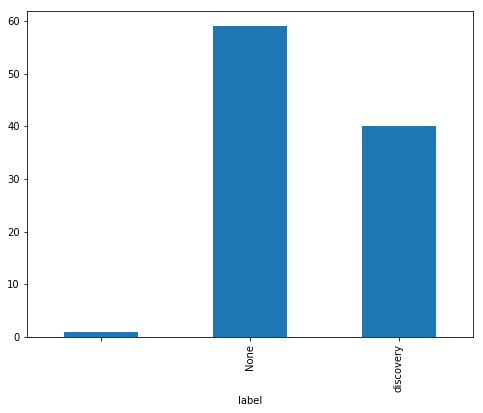

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('label').sent.count().plot.bar(ylim=0)
plt.show()

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.sent).toarray()
labels = np.array(df.category_id.astype(float))
features.shape

(100, 44)

In [12]:
feature_names

NameError: name 'feature_names' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['sent'], df['label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [ ]:
print(clf.predict(count_vect.transform([df.sent[0]])))

In [ ]:
print(clf.predict(count_vect.transform([df.sent[20]])))

In [ ]:
df[df['sent'] == df.sent[0]]

In [ ]:
df[df['sent'] == df.sent[20]]

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

In [ ]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=list(set(category_id_df.label.values)), yticklabels=list(set(category_id_df.label.values)))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 6:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['label', 'sent']])
            print('')

In [ ]:
model.fit(features, labels)

In [ ]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

In [ ]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['label'].unique()))